<a href="https://colab.research.google.com/github/abi672003/Toxic-Comment-Classification-using-RNN-and-LSTM/blob/main/Mini_Project_49.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Toxic Comment Classification using RNN and LSTM.ipynb**

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import string
import tensorflow as tf
import sklearn as sk # For AUC/ROC analysis


# For filtering stopwords
from nltk.corpus import stopwords

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# File names
TRAINING_DATA_PATH = "/content/train.csv"
VALIDATION_DATA_PATH = "/content/validation.csv"

# Load the data
training_dataframe = pd.read_csv(TRAINING_DATA_PATH)
validation_dataframe = pd.read_csv(VALIDATION_DATA_PATH)

# Verify Data is downloaded
display(training_dataframe)
display(validation_dataframe)

print("Train Shape:", training_dataframe.shape)
print("Validation Shape:", training_dataframe.shape)
print("Validation %:", 100* len(validation_dataframe)/len(training_dataframe))


,id,comment_text,lang,toxic
0,0,Este usuario ni siquiera llega al rango de ...,es,0
1,1,Il testo di questa voce pare esser scopiazzato...,it,0
2,2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,es,1
3,3,Bu maddenin alt başlığı olarak uluslararası i...,tr,0
4,4,Belçika nın şehirlerinin yanında ilçe ve belde...,tr,0
...,...,...,...,...
7995,7995,Il fatto è che la pagina dei personaggi minor...,it,0
7996,7996,El imbesil ete dela luna no se entera ni ostia...,es,1
7997,7997,olum sız manyakmısınz siz adam sıze sanal yıld...,tr,1
7998,7998,El mapa del reinado de Alhaken esta ligerament...,es,0


,id,comment_text,lang,toxic
0,0,Este usuario ni siquiera llega al rango de ...,es,0
1,1,Il testo di questa voce pare esser scopiazzato...,it,0
2,2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,es,1
3,3,Bu maddenin alt başlığı olarak uluslararası i...,tr,0
4,4,Belçika nın şehirlerinin yanında ilçe ve belde...,tr,0
...,...,...,...,...
7995,7995,Il fatto è che la pagina dei personaggi minor...,it,0
7996,7996,El imbesil ete dela luna no se entera ni ostia...,es,1
7997,7997,olum sız manyakmısınz siz adam sıze sanal yıld...,tr,1
7998,7998,El mapa del reinado de Alhaken esta ligerament...,es,0


Train Shape: (8000, 4)
Validation Shape: (8000, 4)
Validation %: 100.0


In [ ]:
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
OOV_TOKEN = "<OOV>"
MAX_LENGTH = 20 # How long each input should be
VOCABULARY_LIMIT = 100000 # How large our vocabulary should be
THRESHOLD = 0.5 # Threshold used in Data Anaylsis. probability > threshold = toxic
TRAINING_COUNT = 500000 # How many training inputs to use.

# NOTE: We do not convert to a numpy array just yet, as we need to process the data
x_train = training_dataframe["comment_text"][:TRAINING_COUNT]
x_validation = validation_dataframe["comment_text"]

y_train = training_dataframe["toxic"][:TRAINING_COUNT]
y_validation = validation_dataframe["toxic"]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def remove_stopwords(sequences):
    return sequences.apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))


def remove_punctuations(sequences):
    return sequences.str.replace('[{}]'.format(string.punctuation), '')


def lowercase_all(sequences):
    return sequences.str.lower()

def cleanse_data(sequences):
    sequences = remove_punctuations(sequences)
    sequences = lowercase_all(sequences)
    return remove_stopwords(sequences).to_numpy()


x_train_cleansed = cleanse_data(x_train)
x_validation_cleansed = cleanse_data(x_validation)

print(x_train[0])
print(x_train_cleansed[0])

<ipython-input-46-9e7031184dbe>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  return sequences.str.replace('[{}]'.format(string.punctuation), '')


Este usuario ni siquiera llega al rango de    hereje   . Por lo tanto debería ser quemado en la barbacoa para purificar su alma y nuestro aparato digestivo mediante su ingestión.    Skipe linkin 22px   Honor, valor, leltad.      17:48 13 mar 2008 (UTC)
este usuario ni siquiera llega al rango de hereje por lo tanto debería ser quemado en la barbacoa para purificar su alma nuestro aparato digestivo mediante su ingestión skipe linkin 22px honor valor leltad 1748 13 mar 2008 utc


In [ ]:
# Predict the average of all probabilities as the baseline model for the experiment
predicted_average = y_train.mean()
# Make the same prediction for every label in the training set
prediction = [predicted_average for i in range(len(y_validation))]
print("Baseline Prediction", prediction[:10])

# Generate the dataframe, and generate the .csv
validation_predictions = {
    "id": [],
    "toxic": []
}


for i in range(len(validation_dataframe)):
    validation_predictions["id"].append(i)
    validation_predictions["toxic"].append(prediction)


validation_results = pd.DataFrame(validation_predictions)

display(validation_results)

Baseline Prediction [0.15375, 0.15375, 0.15375, 0.15375, 0.15375, 0.15375, 0.15375, 0.15375, 0.15375, 0.15375]


,id,toxic
0,0,"[0.15375, 0.15375, 0.15375, 0.15375, 0.15375, ..."
1,1,"[0.15375, 0.15375, 0.15375, 0.15375, 0.15375, ..."
2,2,"[0.15375, 0.15375, 0.15375, 0.15375, 0.15375, ..."
3,3,"[0.15375, 0.15375, 0.15375, 0.15375, 0.15375, ..."
4,4,"[0.15375, 0.15375, 0.15375, 0.15375, 0.15375, ..."
...,...,...
7995,7995,"[0.15375, 0.15375, 0.15375, 0.15375, 0.15375, ..."
7996,7996,"[0.15375, 0.15375, 0.15375, 0.15375, 0.15375, ..."
7997,7997,"[0.15375, 0.15375, 0.15375, 0.15375, 0.15375, ..."
7998,7998,"[0.15375, 0.15375, 0.15375, 0.15375, 0.15375, ..."


In [ ]:
# Prediction Evaluation using ROC & AUC Score
# y_train parameter should contain binary labels (0 & 1)
# Prediction parameter expects the predicted probabilities of the positive class
auc_roc_score = sk.metrics.roc_auc_score(y_validation,prediction)
print("ROC & AUC Score:", auc_roc_score)

ROC & AUC Score: 0.5


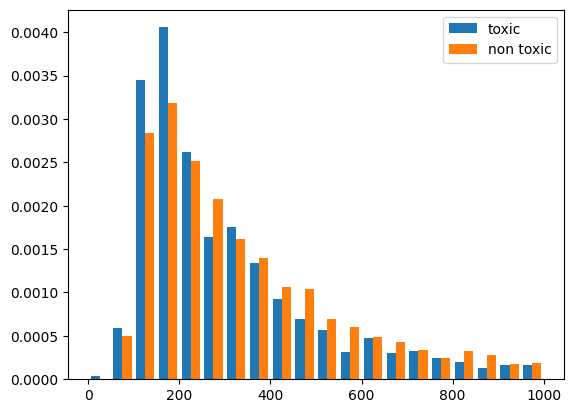

Largest Toxic Comment:  1372
Largest Non Toxic Comment: 1785


In [ ]:
# Create a list to store the lengths of the toxic comments found in the data set
toxic_comments_lengths = [len(x_train[i]) for i in range(len(x_train)) if y_train[i] >= THRESHOLD]
# Create a list to store the lengths of the non toxic comments found in the data set
non_toxic_comments_lengths = [len(x_train[i]) for i in range(len(x_train)) if y_train[i] < THRESHOLD]


# Plot a histogram graph to observe the lengths of each comment and how many comments have a specific length
plt.hist([toxic_comments_lengths, non_toxic_comments_lengths],  density=True, bins=20, range=(0, 1000), label=['toxic','non toxic'])
plt.legend()
plt.show()

# Verify the largest toxic comment for toxic and non toxic
print("Largest Toxic Comment: ", max(toxic_comments_lengths))
print("Largest Non Toxic Comment:", max(non_toxic_comments_lengths))

In [ ]:
# Word to [positive, negative] count list
word_count = dict()

for i, comment in enumerate(x_train_cleansed):
    for word in comment.split():

        # Default value = [0, 0]
        if word not in word_count:
            word_count[word] = [0,0]

        # Increase count
        word_count[word][int(y_train[i] >= THRESHOLD)] += 1



# Turn dictionaries into lists, for easy sorting
word_count_list = list(word_count.items())

# Sort by frequency
p_count_list = sorted(word_count_list, key = lambda x: x[1][0], reverse = True)
n_count_list = sorted(word_count_list, key = lambda x: x[1][1], reverse = True)

WORDS_TO_DISPLAY = 10

# Print top 10 words for both
print("Positive Comment word frequency")
print("Word,\tCount")
for i in range(WORDS_TO_DISPLAY):
    print(p_count_list[i][0], "\t" , p_count_list[i][1][0])

print("==========")
print("Negative Comment word frequency")
print("Word,\tCount")
for i in range(WORDS_TO_DISPLAY):
    print(n_count_list[i][0], "\t" , n_count_list[i][1][1])

Positive Comment word frequency
Word,	Count
de 	 6744
la 	 5275
que 	 4888
bir 	 3195
di 	 3071
che 	 3020
un 	 2960
en 	 2946
el 	 2635
e 	 2519
Negative Comment word frequency
Word,	Count
de 	 1127
la 	 902
que 	 883
che 	 785
di 	 710
e 	 673
un 	 654
non 	 581
el 	 426
lo 	 393


In [ ]:
# x[1][0] = positive count
# x[1][1] = negative count
# Sum them together for total frequency
# TODO: There is an issue. Because negative comments are barely present in the data set
# Negative words might be cut out first in favor of positive words
vocabulary = sorted(word_count_list, key = lambda x: x[1][0] + x[1][1], reverse = True)

# Limit vocabulary to K words
vocabulary = vocabulary[:VOCABULARY_LIMIT]

# Remove counts, we only care about the words
vocabulary = [OOV_TOKEN] + [x[0] for x in vocabulary]

# Create the vocabulary and reverse dictionaries
id_to_word = dict([(key, value) for (key, value) in enumerate(vocabulary)])
word_to_id = dict([(value, key) for (key, value) in enumerate(vocabulary)])

In [ ]:
def decode(sequence):
    return " ".join([id_to_word.get(i, OOV_TOKEN) for i in sequence])

def encode(comment):
    return [word_to_id.get(word, 0) for word in comment.split()]


def pad_data(sequences, max_length = MAX_LENGTH):
    # Pads each numerical array to a certain length
    return np.array(list(
        tf.keras.preprocessing.sequence.pad_sequences(
          sequences, dtype=object, maxlen=max_length, padding='post', value=0)))

def text_to_sequences(comments):
    # Encodes each comment into a numerical array
    return np.array([encode(comment) for comment in comments])

def process_data(x_input):
    return pad_data(text_to_sequences(x_input)).astype(int)

x_train_processed = process_data(x_train_cleansed)
x_validation_processed = process_data(x_validation_cleansed)

print(x_train_processed[0])

[26428    34  4481  2045 16322 26429  3352    34 26430 26431  9650  9651
  5453  4102 26432 12082  1138  1225   460    79]


<ipython-input-52-e9185717c92f>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([encode(comment) for comment in comments])


**Model**

Currently Evaluating Dimension: 2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 2)             200002    
                                                                 
 conv1d (Conv1D)             (None, 17, 32)            288       
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 200,323
Trainable params: 200,323
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
113/113 [==============================] - 3s 6ms/step - loss: 0.5939 - 

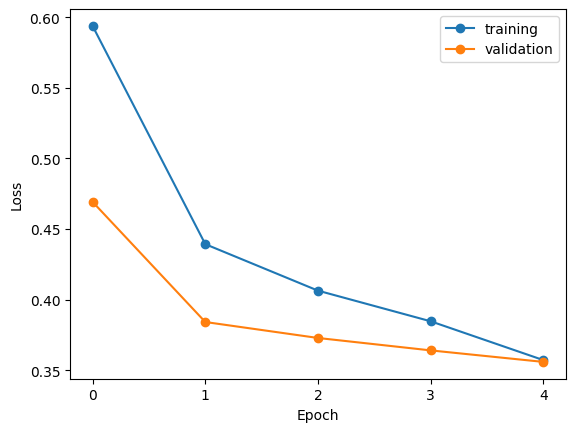

250/250 [==============================] - 0s 1ms/step
AUC/ROC Score: 0.9467246700531998
Currently Evaluating Dimension: 4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 4)             400004    
                                                                 
 conv1d (Conv1D)             (None, 17, 32)            544       
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 400,581
Trainable params: 400,581
Non-trainable params: 0
___________________________________________________________

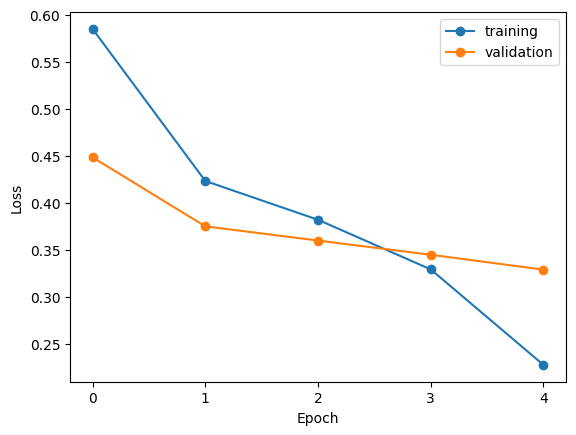

250/250 [==============================] - 0s 1ms/step
AUC/ROC Score: 0.982944002113581
Currently Evaluating Dimension: 8
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 8)             800008    
                                                                 
 conv1d (Conv1D)             (None, 17, 32)            1056      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 801,097
Trainable params: 801,097
Non-trainable params: 0
____________________________________________________________

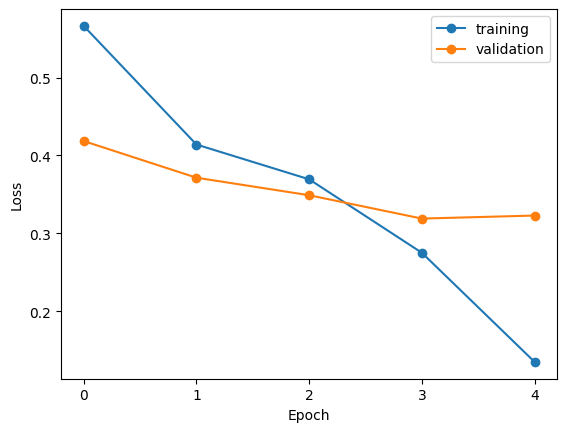

250/250 [==============================] - 0s 1ms/step
AUC/ROC Score: 0.9924292971142413
Currently Evaluating Dimension: 16
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 16)            1600016   
                                                                 
 conv1d (Conv1D)             (None, 17, 32)            2080      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1,602,129
Trainable params: 1,602,129
Non-trainable params: 0
______________________________________________________

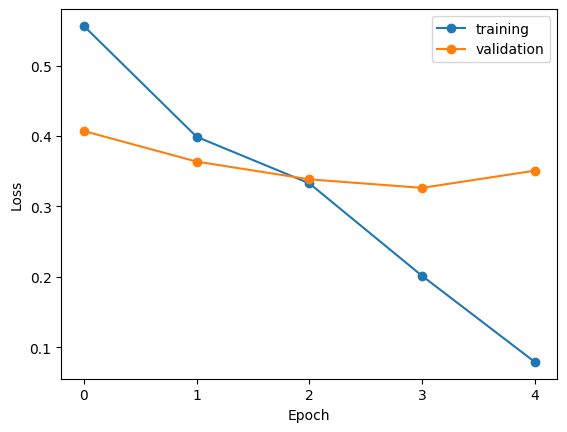

250/250 [==============================] - 1s 1ms/step
AUC/ROC Score: 0.9938345882720274
Currently Evaluating Dimension: 32
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 32)            3200032   
                                                                 
 conv1d (Conv1D)             (None, 17, 32)            4128      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 3,204,193
Trainable params: 3,204,193
Non-trainable params: 0
______________________________________________________

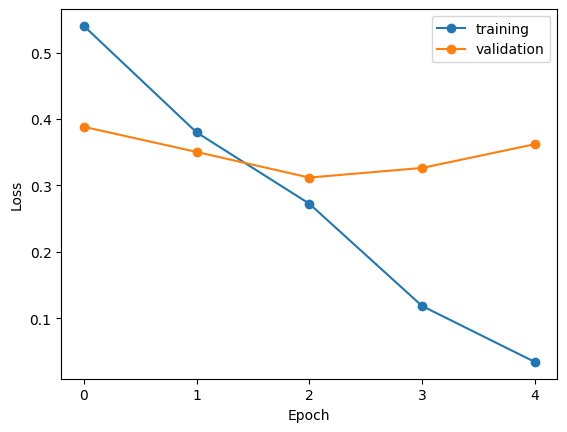

250/250 [==============================] - 0s 1ms/step
AUC/ROC Score: 0.9944938814233046
Currently Evaluating Dimension: 64
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 64)            6400064   
                                                                 
 conv1d (Conv1D)             (None, 17, 32)            8224      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 6,408,321
Trainable params: 6,408,321
Non-trainable params: 0
______________________________________________________

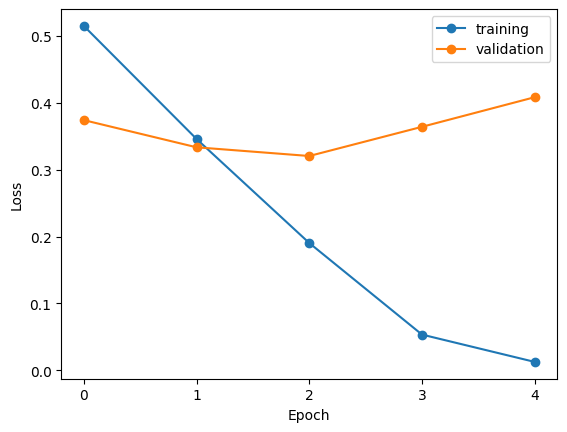

250/250 [==============================] - 0s 1ms/step
AUC/ROC Score: 0.9946710139184112
Currently Evaluating Dimension: 2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 2)             200002    
                                                                 
 flatten (Flatten)           (None, 40)                0         
                                                                 
 dense (Dense)               (None, 64)                2624      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 202,691
Trainable params: 202,691
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
113/113 [==============================] - 1s 5ms

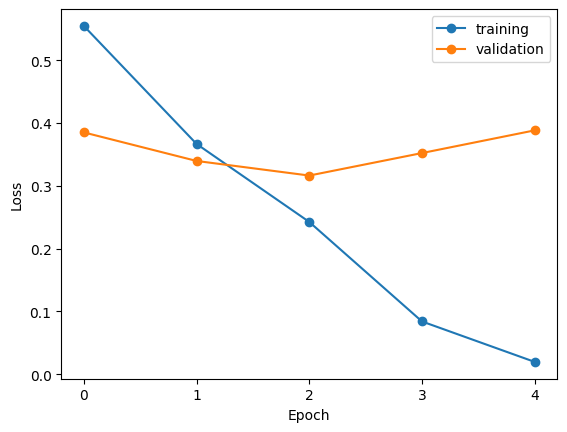

250/250 [==============================] - 0s 957us/step
AUC/ROC Score: 0.9952194641591909
Currently Evaluating Dimension: 4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 4)             400004    
                                                                 
 flatten (Flatten)           (None, 80)                0         
                                                                 
 dense (Dense)               (None, 64)                5184      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 405,253
Trainable params: 405,253
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
113/113 [==============================] - 1s 6

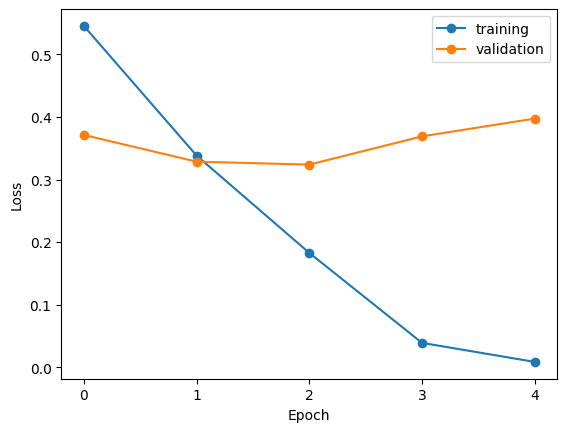

250/250 [==============================] - 0s 1ms/step
AUC/ROC Score: 0.995731287002678
Currently Evaluating Dimension: 8
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 8)             800008    
                                                                 
 flatten (Flatten)           (None, 160)               0         
                                                                 
 dense (Dense)               (None, 64)                10304     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 810,377
Trainable params: 810,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
113/113 [==============================] - 2s 8ms/

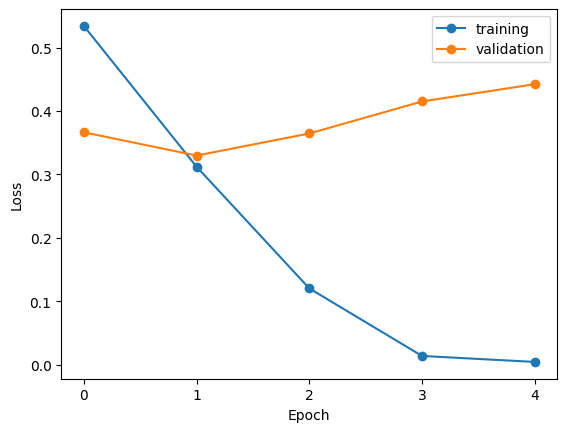

250/250 [==============================] - 0s 999us/step
AUC/ROC Score: 0.9969339866219933
Currently Evaluating Dimension: 16
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 16)            1600016   
                                                                 
 flatten (Flatten)           (None, 320)               0         
                                                                 
 dense (Dense)               (None, 64)                20544     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,620,625
Trainable params: 1,620,625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
113/113 [==============================] -

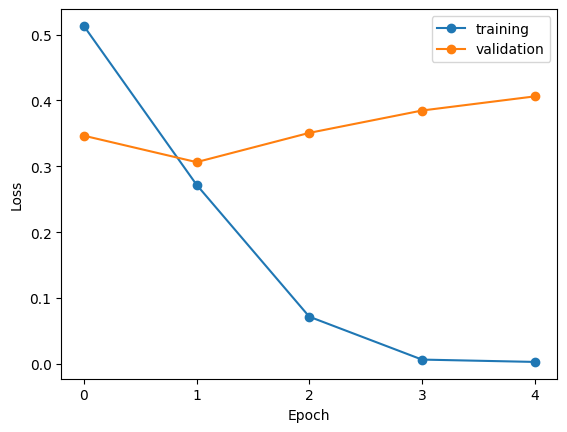

250/250 [==============================] - 0s 1ms/step
AUC/ROC Score: 0.9968164186811735
Currently Evaluating Dimension: 32
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 32)            3200032   
                                                                 
 flatten (Flatten)           (None, 640)               0         
                                                                 
 dense (Dense)               (None, 64)                41024     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 3,241,121
Trainable params: 3,241,121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
113/113 [==============================] - 3

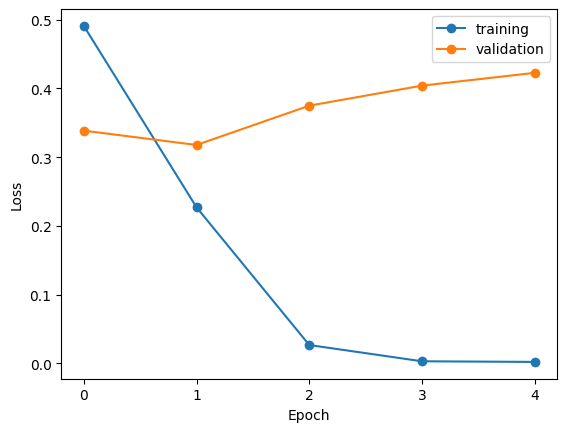

250/250 [==============================] - 0s 1ms/step
AUC/ROC Score: 0.9973658296405712
Currently Evaluating Dimension: 64
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 64)            6400064   
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 64)                81984     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6,482,113
Trainable params: 6,482,113
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
113/113 [==============================] - 7

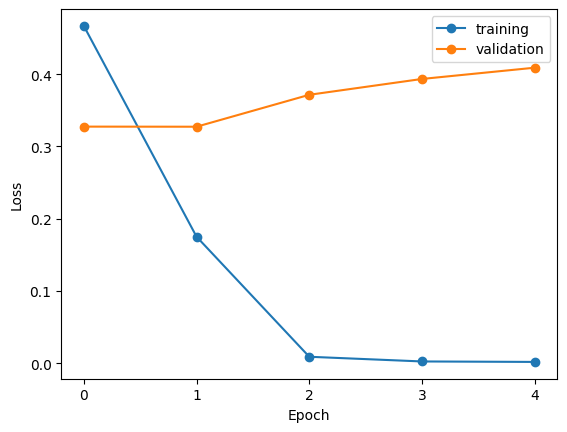

250/250 [==============================] - 0s 1ms/step
AUC/ROC Score: 0.9976473201955063


In [ ]:
def plot_history(history):
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xticks(range(0, len(history['loss'] + 1)))
    plt.plot(history['loss'], label="training", marker='o')
    plt.plot(history['val_loss'], label="validation", marker='o')
    plt.legend()
    plt.show()
def build_model(embedding_dim = 16, dropout_rate = 0.5):
    # Clear session and remove randomness.
    tf.keras.backend.clear_session()
    tf.keras.utils.set_random_seed(0)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(
        input_dim=VOCABULARY_LIMIT+1, # add 1 because of the OOV token
        output_dim=embedding_dim,
        input_length=MAX_LENGTH)
    )

    model.add(tf.keras.layers.Conv1D(
        filters=32, # number of filters (i.e., output channels)
        kernel_size=4, # width of the filters
        activation='relu' # activation function to use
    ))

    model.add(tf.keras.layers.GlobalMaxPooling1D())
    model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))


    model.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=[tf.keras.metrics.AUC()])
    return model
def build_embeddings_model(embedding_dim=2):
    """Build a tf.keras model using embeddings"""
    tf.keras.backend.clear_session()
    # Eliminate Randomness factor for consistent results
    tf.keras.utils.set_random_seed(0)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(
        input_dim=VOCABULARY_LIMIT+1, # add 1 because of the OOV token
        output_dim=embedding_dim,
        input_length=MAX_LENGTH)
    )

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(
        units=64,
        activation='relu'))

    model.add(tf.keras.layers.Dense(
        units=1,
        activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=[tf.keras.metrics.AUC()])

    return model
dimensions = [2, 4, 8, 16, 32, 64]

models = [build_model, build_embeddings_model]

for build_m in models:
    for d in dimensions:
        print("Currently Evaluating Dimension:", d)
        model = build_m(d)
        model.summary()

        # Train the model
        history = model.fit(
            x = x_train_processed,
            y = y_train,
            epochs=5,                    # number of passes through the training data
            batch_size=64,                    # mini-batch size
            validation_split=0.1,# use a fraction of the examples for validation
            verbose=1                         # display some progress output during training
        )

        history = pd.DataFrame(history.history)
        plot_history(history)

        # Predict on the validation data
        results = model.predict(x = x_validation_processed)

        # Calculate Kaggle Score:
        print("AUC/ROC Score:", sk.metrics.roc_auc_score(y_validation, results))
        print("=================")


250/250 [==============================] - 0s 1ms/step


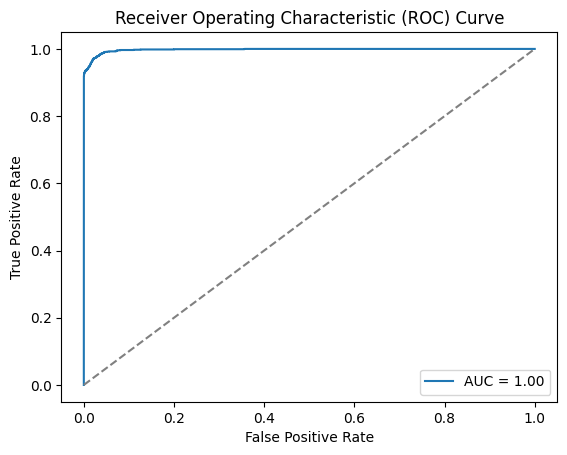

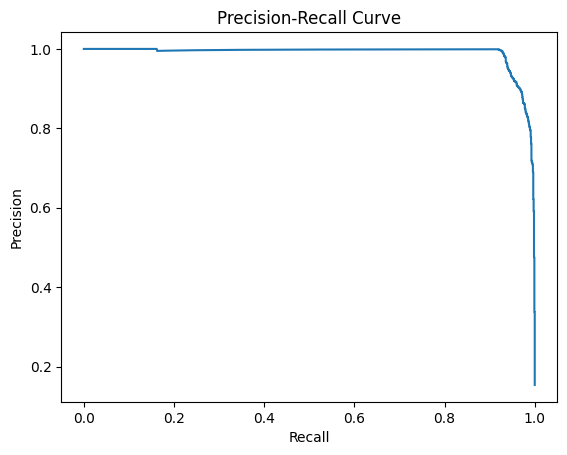

In [ ]:
# Get predicted probabilities for the test data
validation_predictions = model.predict(x_validation_processed)


print("========")

# Compute false positive rate and true positive rate
fpr, tpr, thresholds = sk.metrics.roc_curve(y_validation, validation_predictions)

# Compute the area under the curve (AUC)
auc_score = sk.metrics.roc_auc_score(y_validation, validation_predictions)

# Plot the ROC curve
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Calculate precision and recall for different thresholds
precision, recall, thresholds = sk.metrics.precision_recall_curve(y_validation, validation_predictions)

# Plot the precision-recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()